# Capstone Proyek : [Prediksi Penyakit Tanaman Berbasis Citra]

## Import Semua Packages/Library yang Digunakan

In [9]:
# Import library yang diperlukan
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.applications import MobileNetV2
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import zipfile
from google.colab import files
from google.colab import drive
import cv2
import shutil, random

# Cek versi
print("TensorFlow version:", tf.__version__)
print("Pandas version:", pd.__version__)
print("Python version:", sys.version)

# Cek GPU
print("GPU available:", tf.config.list_physical_devices('GPU'))

# Mengabaikan peringatan
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

TensorFlow version: 2.18.0
Pandas version: 2.2.2
Python version: 3.11.12 (main, Apr  9 2025, 08:55:54) [GCC 11.4.0]
GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Data Preparation

### Data Loading

### 1. Mount Google Drive

In [10]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### 2. Ekstraksi ZIP Dataset

In [11]:
zip_path = "/content/drive/MyDrive/Model CP/4 dataset citra daun tanaman.zip"
extract_path = "dataset"

if not os.path.exists(extract_path):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
    print("Dataset berhasil diekstrak.")
else:
    print("Folder sudah ada, tidak perlu ekstrak ulang.")

Folder sudah ada, tidak perlu ekstrak ulang.


### 3. Cek isi folder

In [13]:
path_kelas = "/content/dataset/4 dataset citra daun tanaman"
print("Daftar kelas dalam dataset:")
print(os.listdir(path_kelas))

Daftar kelas dalam dataset:
['Tomato__yellow_leaf_curl_virus', 'Tomato__early_blight', 'Corn__common_rust', 'Tomato__late_blight', 'Corn__northern_leaf_blight', 'Tomato__healthy', 'Corn__gray_leaf_spot', 'Rice__leaf_blast', 'Chili__leaf curl', 'Rice__healthy', 'Chili__healthy', 'Rice__neck_blast', 'Chili__whitefly', 'Chili__leaf spot', 'Rice__brown_spot', 'Corn__healthy']


### 4. Set seed

In [14]:
np.random.seed(42)
tf.random.set_seed(42)

### Data Preprocessing

#### Split Dataset

### 5. Split Dataset ke Train / Validation / Test

In [15]:
original_dataset_dir = os.path.join(extract_path, '4 dataset citra daun tanaman')
split_base_dir = os.path.join(extract_path, 'dataset_split')
train_dir = os.path.join(split_base_dir, 'train')
valid_dir = os.path.join(split_base_dir, 'validation')
test_dir  = os.path.join(split_base_dir, 'test')

for dir_path in [train_dir, valid_dir, test_dir]:
    os.makedirs(dir_path, exist_ok=True)

train_ratio = 0.7
val_ratio = 0.2
test_ratio = 0.1

for class_name in os.listdir(original_dataset_dir):
    class_path = os.path.join(original_dataset_dir, class_name)
    if not os.path.isdir(class_path):
        continue

    images = os.listdir(class_path)
    random.shuffle(images)

    total = len(images)
    train_len = int(train_ratio * total)
    val_len = int(val_ratio * total)

    train_images = images[:train_len]
    val_images = images[train_len:train_len + val_len]
    test_images = images[train_len + val_len:]

    def copy_images(image_list, target_root):
        class_target_dir = os.path.join(target_root, class_name)
        os.makedirs(class_target_dir, exist_ok=True)
        for img in image_list:
            src = os.path.join(class_path, img)
            dst = os.path.join(class_target_dir, img)
            shutil.copy2(src, dst)

    copy_images(train_images, train_dir)
    copy_images(val_images, valid_dir)
    copy_images(test_images, test_dir)

print("Dataset berhasil dibagi menjadi Train (70%), Validation (20%), dan Test (10%).")

Dataset berhasil dibagi menjadi Train (70%), Validation (20%), dan Test (10%).


### 6. Update path dataset

In [16]:
base_dir = split_base_dir
train_dir = os.path.join(base_dir, 'train')
valid_dir = os.path.join(base_dir, 'validation')
test_dir  = os.path.join(base_dir, 'test')

### 7. Cek jumlah kelas dan gambar

In [17]:
num_classes = len(os.listdir(train_dir))
train_count = sum([len(files) for r, d, files in os.walk(train_dir)])
test_count = sum([len(files) for r, d, files in os.walk(test_dir)])
valid_count = sum([len(files) for r, d, files in os.walk(valid_dir)])

print(f"\nJumlah kelas            : {num_classes}")
print(f"Jumlah gambar training  : {train_count}")
print(f"Jumlah gambar validasi  : {valid_count}")
print(f"Jumlah gambar testing   : {test_count}")


Jumlah kelas            : 16
Jumlah gambar training  : 11929
Jumlah gambar validasi  : 3403
Jumlah gambar testing   : 1717


### 8. Pengecekan resolusi gambar contoh

In [18]:
sample_img_path = os.path.join(train_dir, os.listdir(train_dir)[0], os.listdir(os.path.join(train_dir, os.listdir(train_dir)[0]))[0])
sample_img = plt.imread(sample_img_path)
print(f"\n Ukuran gambar contoh    : {sample_img.shape}")


 Ukuran gambar contoh    : (256, 256, 3)


### 9. Visualisasi contoh gambar

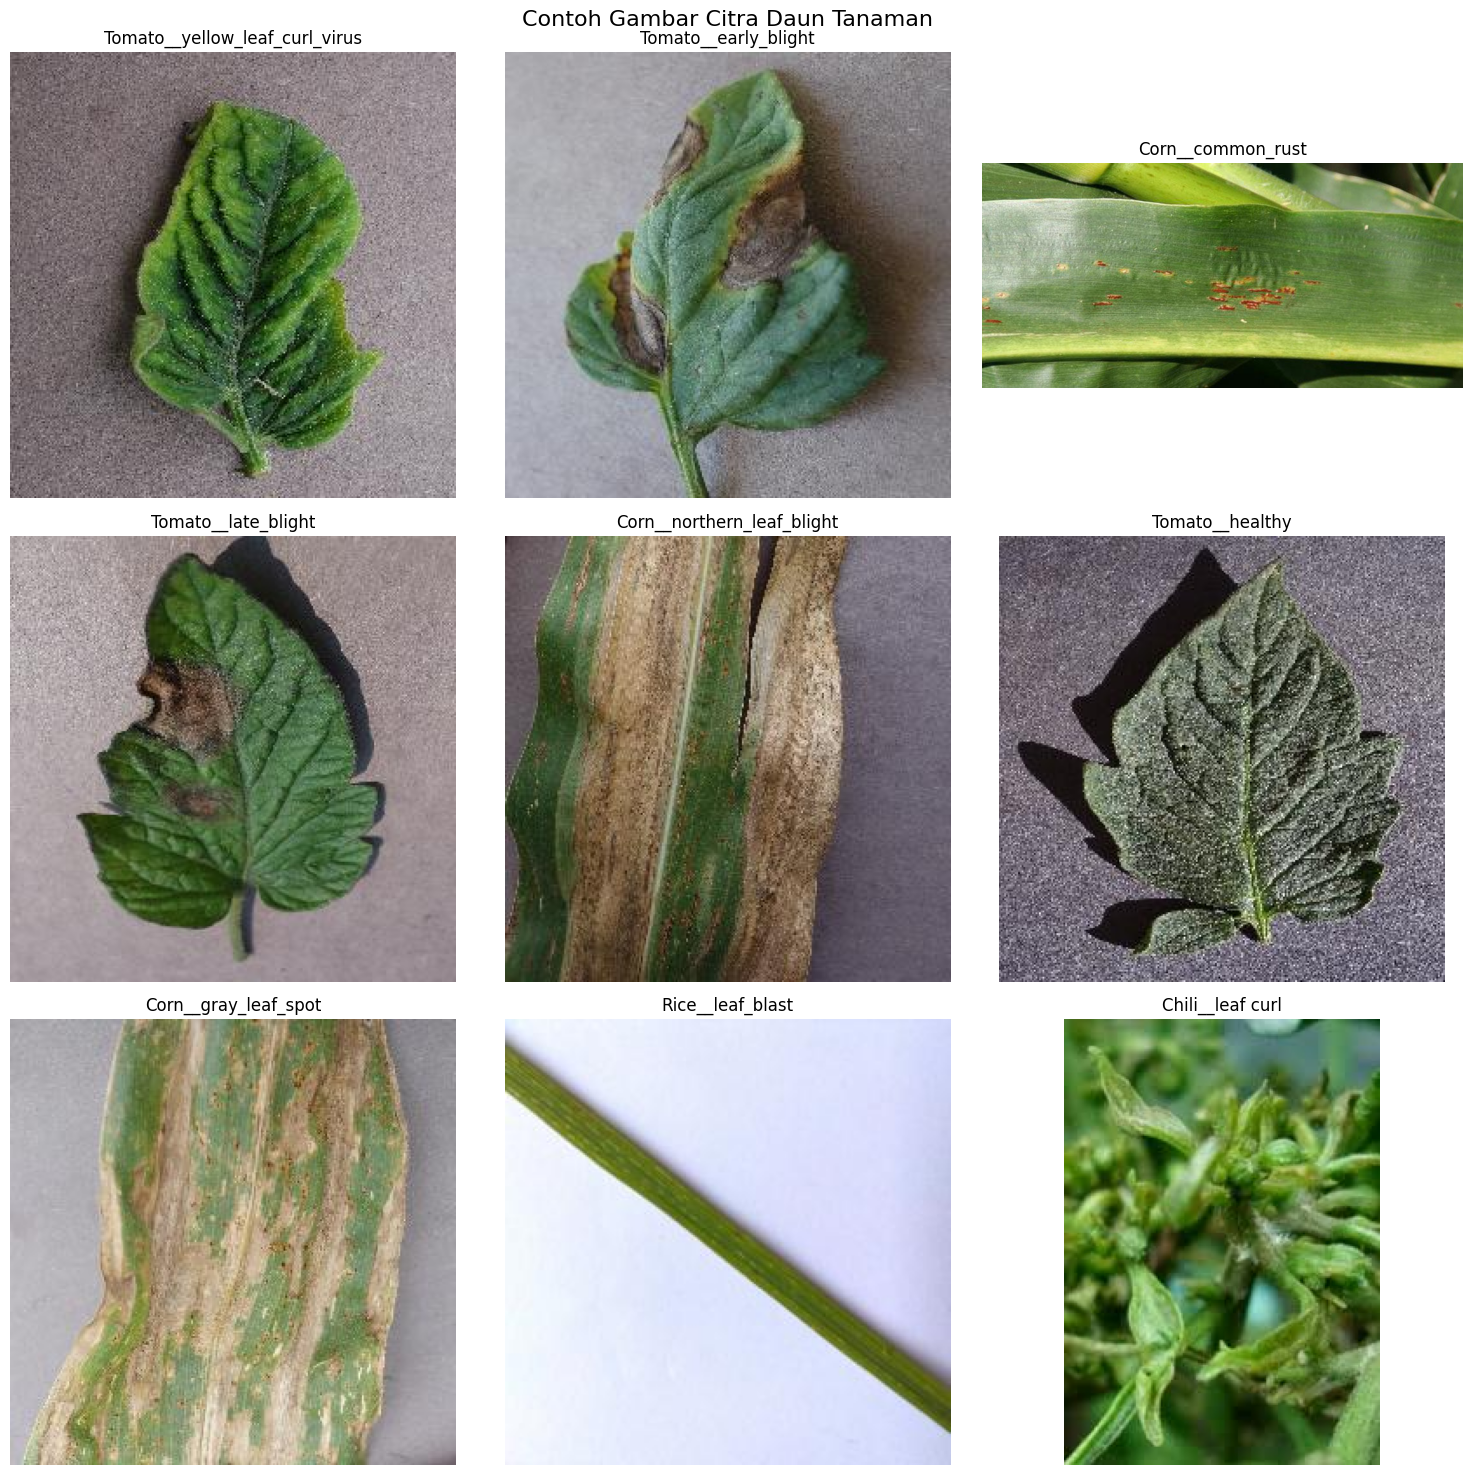

In [19]:
plt.figure(figsize=(15, 15))
species_dirs = os.listdir(train_dir)[:9]

for i, species in enumerate(species_dirs):
    img_path = os.path.join(train_dir, species, os.listdir(os.path.join(train_dir, species))[0])
    img = plt.imread(img_path)
    plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    plt.title(species)
    plt.axis('off')

plt.suptitle("Contoh Gambar Citra Daun Tanaman", fontsize=16)
plt.tight_layout()
plt.show()

In [20]:
# Menentukan dimensi gambar dan parameter lainnya
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32

# Data Augmentation untuk training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Hanya rescaling untuk validasi dan testing
valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Membuat generator
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

valid_generator = valid_datagen.flow_from_directory(
    valid_dir,  # Diubah dari train_dir ke valid_dir
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    test_dir,  # Diubah dari train_dir ke test_dir
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# Mendapatkan class indices dan nama kelas
class_indices = train_generator.class_indices
class_names = list(class_indices.keys())
print("Nama kelas:", class_names[:5], "...")  # Menampilkan 5 kelas pertama

# Menyimpan label untuk TFLite
with open('class_names.txt', 'w') as f:
    for class_name in class_names:
        f.write(f"{class_name}\n")

Found 11929 images belonging to 16 classes.
Found 3403 images belonging to 16 classes.
Found 1717 images belonging to 16 classes.
Nama kelas: ['Chili__healthy', 'Chili__leaf curl', 'Chili__leaf spot', 'Chili__whitefly', 'Corn__common_rust'] ...


## Modelling

In [21]:
# Mengubah Arsitektur Model dengan Dropout yang lebih banyak dan Regularisasi L2
def create_model_modified(input_shape, num_classes):
    model = Sequential([
        # Blok Konvolusi 1
        Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        BatchNormalization(),
        Conv2D(32, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.3), # Meningkatkan Dropout

        # Blok Konvolusi 2
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.3), # Meningkatkan Dropout

        # Blok Konvolusi 3
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.4), # Meningkatkan Dropout

        # Blok Konvolusi 4 (Opsional: bisa dihapus jika ingin mengurangi kompleksitas)
        Conv2D(256, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(256, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.4), # Meningkatkan Dropout


        # Fully Connected Layers
        Flatten(),
        Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)), # Menambahkan Regularisasi L2
        BatchNormalization(),
        Dropout(0.6), # Meningkatkan Dropout
        Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)), # Menambahkan Regularisasi L2
        BatchNormalization(),
        Dropout(0.6), # Meningkatkan Dropout
        Dense(num_classes, activation='softmax')
    ])

    # Kompilasi model dengan Learning Rate yang lebih kecil (opsional)
    model.compile(
        optimizer=optimizers.Adam(learning_rate=0.0005), # Mengurangi learning rate
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# Buat model dengan arsitektur yang dimodifikasi
input_shape = (IMG_HEIGHT, IMG_WIDTH, 3)
model = create_model_modified(input_shape, num_classes)

# Tampilkan ringkasan model
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 224, 224, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 112, 112, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 56, 56, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 28, 28, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 27,005,232 (103.02 MB)

 Trainable params: 27,001,776 (103.00 MB)

 Non-trainable params: 3,456 (13.50 KB)

In [22]:
# Callbacks
checkpoint_path = "/content/drive/MyDrive/Model CP/models/best_model.keras"

checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    mode='max'
)

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

callbacks = [checkpoint, early_stopping, reduce_lr]

# Training model
EPOCHS = 30

history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=EPOCHS,
    validation_data=valid_generator,
    validation_steps=len(valid_generator),
    callbacks=callbacks
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
373/373 ━━━━━━━━━━━━━━━━━━━━ 0s 680ms/step - accuracy: 0.4241 - loss: 3.7256
Epoch 1: val_accuracy improved from -inf to 0.15163, saving model to /content/drive/MyDrive/Model CP/models/best_model.keras
373/373 ━━━━━━━━━━━━━━━━━━━━ 318s 773ms/step - accuracy: 0.4244 - loss: 3.7243 - val_accuracy: 0.1516 - val_loss: 7.9445 - learning_rate: 5.0000e-04
Epoch 2/30
373/373 ━━━━━━━━━━━━━━━━━━━━ 0s 614ms/step - accuracy: 0.6621 - loss: 2.6425
Epoch 2: val_accuracy improved from 0.15163 to 0.66353, saving model to /content/drive/MyDrive/Model CP/models/best_model.keras
373/373 ━━━━━━━━━━━━━━━━━━━━ 256s 684ms/step - accuracy: 0.6621 - loss: 2.6421 - val_accuracy: 0.6635 - val_loss: 2.4839 - learning_rate: 5.0000e-04
Epoch 3/30
373/373 ━━━━━━━━━━━━━━━━━━━━ 0s 618ms/step - accuracy: 0.7173 - loss: 2.1660
Epoch 3: val_accuracy improved from 0.66353 to 0.76579, saving model to /content/drive/MyDrive/Model CP/models/best_model.keras
373/373 ━━━━━━━━━━━━━━━━━━━━ 261s 700ms/step - accuracy: 

## Evaluasi dan Visualisasi

54/54 ━━━━━━━━━━━━━━━━━━━━ 22s 405ms/step - accuracy: 0.8532 - loss: 0.7520

Test Loss: 0.5812
Test Accuracy: 90.68%


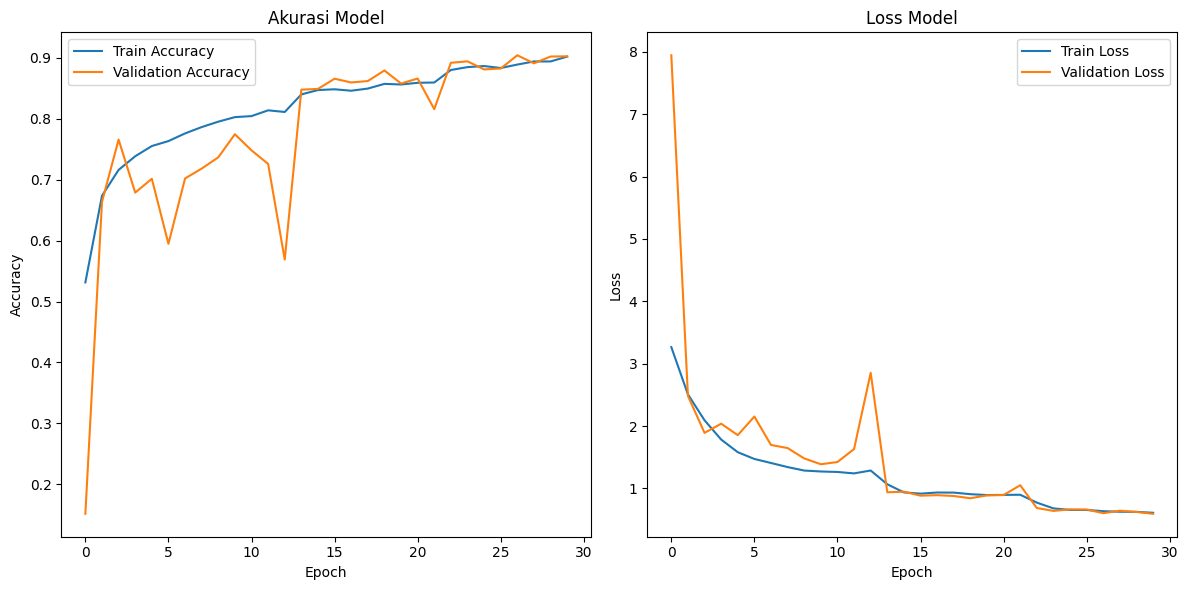

In [23]:
# Evaluasi model pada data TEST
test_loss, test_accuracy = model.evaluate(test_generator, steps=len(test_generator), verbose=1)
print(f"\nTest Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy*100:.2f}%")

# Visualisasi Akurasi dan Loss
history_dict = history.history

plt.figure(figsize=(12, 6))

# Plot Akurasi
plt.subplot(1, 2, 1)
plt.plot(history_dict['accuracy'], label='Train Accuracy')
plt.plot(history_dict['val_accuracy'], label='Validation Accuracy')
plt.title('Akurasi Model')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history_dict['loss'], label='Train Loss')
plt.plot(history_dict['val_loss'], label='Validation Loss')
plt.title('Loss Model')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

## Konversi Model

In [24]:
keras_model_path = "/content/drive/MyDrive/Model CP/models/best_model.keras"
model = load_model(keras_model_path)

In [25]:
# Path tujuan
saved_model_dir = '/content/drive/MyDrive/Model CP/models/saved_model'
os.makedirs(saved_model_dir, exist_ok=True)

# Simpan model
model.export(saved_model_dir)
print("✅ Model disimpan dalam format SavedModel di:", saved_model_dir)

Saved artifact at '/content/drive/MyDrive/Model CP/models/saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 16), dtype=tf.float32, name=None)
Captures:
  137251655776208: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137251655773520: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137251761171792: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137251761164880: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137251761174480: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137251761174864: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137251761173520: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137251761173904: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137251761171216: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137251761171984: TensorSpec(shape=(), dtype=tf.res

In [26]:
# Path
saved_model_dir = '/content/drive/MyDrive/Model CP/models/saved_model'
tflite_dir = '/content/drive/MyDrive/Model CP/models/tflite'
os.makedirs(tflite_dir, exist_ok=True)

# Konversi
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

# Simpan model TFLite
tflite_path = os.path.join(tflite_dir, 'model.tflite')
with open(tflite_path, 'wb') as f:
    f.write(tflite_model)

# Salin label file
os.system(f'cp class_names.txt {os.path.join(tflite_dir, "label.txt")}')

print("✅ Model berhasil dikonversi ke format TFLite dan disimpan di:", tflite_dir)


✅ Model berhasil dikonversi ke format TFLite dan disimpan di: /content/drive/MyDrive/Model CP/models/tflite


In [37]:
# Path
saved_model_dir = '/content/drive/MyDrive/Model CP/models/saved_model'
tfjs_dir = '/content/drive/MyDrive/Model CP/models/tfjs_model'
os.makedirs(tfjs_dir, exist_ok=True)

# Konversi ke TFJS
os.system(f'tensorflowjs_converter --input_format=tf_saved_model --output_format=tfjs_graph_model {saved_model_dir} {tfjs_dir}')

print("✅ Model berhasil dikonversi ke format TensorFlow.js dan disimpan di:", tfjs_dir)


✅ Model berhasil dikonversi ke format TensorFlow.js dan disimpan di: /content/drive/MyDrive/Model CP/models/tfjs_model


## Inference

Saving image2.jpg to image2.jpg


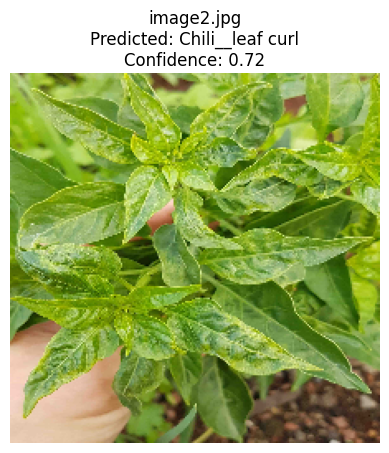

In [34]:
# Path ke model dan labels
tflite_path = "/content/drive/MyDrive/Model CP/models/tflite/model.tflite"
labels_path = "/content/drive/MyDrive/Model CP/models/class_names.txt"

def tflite_inference(img_path, tflite_model_path, labels_path):
    # Load model
    interpreter = tf.lite.Interpreter(model_path=tflite_model_path)
    interpreter.allocate_tensors()

    # Input/output detail
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    # Load & preprocessing gambar
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0

    # Set dan jalankan inference
    interpreter.set_tensor(input_details[0]['index'], img_array)
    interpreter.invoke()

    # Output prediksi
    predictions = interpreter.get_tensor(output_details[0]['index'])
    pred_class_idx = np.argmax(predictions[0])
    confidence = predictions[0][pred_class_idx]

    # Load label
    with open(labels_path, 'r') as f:
        labels = [line.strip() for line in f.readlines() if line.strip() != '']

    # Validasi index prediksi
    if pred_class_idx >= len(labels):
        print(f"[Warning] Predicted index {pred_class_idx} di luar jumlah label ({len(labels)}).")
        return f"Unknown (index {pred_class_idx})", confidence, img

    return labels[pred_class_idx], confidence, img

# Upload gambar dari lokal
uploaded = files.upload()

# Lakukan inference untuk setiap gambar yang diupload
for filename in uploaded.keys():
    pred_class, confidence, img = tflite_inference(filename, tflite_path, labels_path)

    # Tampilkan hasil
    plt.figure()
    plt.imshow(img)
    plt.title(f"{filename}\nPredicted: {pred_class}\nConfidence: {confidence:.2f}")
    plt.axis('off')
    plt.show()

Saving images (4).jpeg to images (4).jpeg


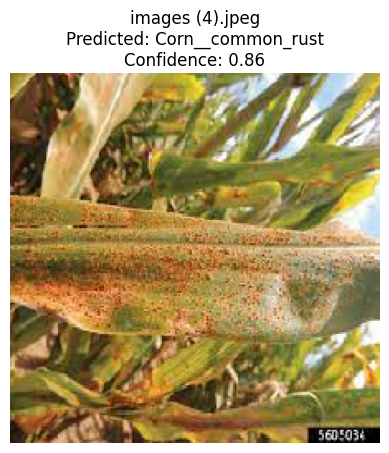

In [35]:
# Path ke model dan labels
tflite_path = "/content/drive/MyDrive/Model CP/models/tflite/model.tflite"
labels_path = "/content/drive/MyDrive/Model CP/models/class_names.txt"

def tflite_inference(img_path, tflite_model_path, labels_path):
    # Load model
    interpreter = tf.lite.Interpreter(model_path=tflite_model_path)
    interpreter.allocate_tensors()

    # Input/output detail
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    # Load & preprocessing gambar
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0

    # Set dan jalankan inference
    interpreter.set_tensor(input_details[0]['index'], img_array)
    interpreter.invoke()

    # Output prediksi
    predictions = interpreter.get_tensor(output_details[0]['index'])
    pred_class_idx = np.argmax(predictions[0])
    confidence = predictions[0][pred_class_idx]

    # Load label
    with open(labels_path, 'r') as f:
        labels = [line.strip() for line in f.readlines() if line.strip() != '']

    # Validasi index prediksi
    if pred_class_idx >= len(labels):
        print(f"[Warning] Predicted index {pred_class_idx} di luar jumlah label ({len(labels)}).")
        return f"Unknown (index {pred_class_idx})", confidence, img

    return labels[pred_class_idx], confidence, img

# Upload gambar dari lokal
uploaded = files.upload()

# Lakukan inference untuk setiap gambar yang diupload
for filename in uploaded.keys():
    pred_class, confidence, img = tflite_inference(filename, tflite_path, labels_path)

    # Tampilkan hasil
    plt.figure()
    plt.imshow(img)
    plt.title(f"{filename}\nPredicted: {pred_class}\nConfidence: {confidence:.2f}")
    plt.axis('off')
    plt.show()